# Exercise 3 - Solutions

As always, first import the libraries which we need throughout the exercise.

In [1]:
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# set a figure size default
plt.rcParams["figure.figsize"] = [10,8]

### 1 Inference

The p-value gives the probability of observing a test result at least as extreme as the result actually observed, under the assumption that the $H_0$ is correct. In regression, we use p-values for hypothesis testing. Assuming e.g. a significance level of 5%, we reject the $H_0$, if $p\leq0.05$ and cannot reject the $H_0$, if the $p>0.05$.

### 2 $R^2$ and correlation
#### a) The $R^2$ in the absolute deviations regression

Here we are supposed to write a function that computes the $R^2$ for LAD. In essence, we have to replace the mean in the formula for the $R^2$ in the least squares case with the median. Note, however, that this is a "pseudo $R^2$".

In [2]:
def rsq_lad(predictions, y):
    """
    This function computes the R^2 of LAD.
    
    Parameters
    ----------
        predictions : the models predictions
        y           : the original data
        
    Returns
    -------
        The coefficient of determination
    """
    
    # compute the elements of R^2
    lower = np.sum(abs(y - np.median(y)))
    upper = np.sum(abs(y - predictions))
    
    # return the R^2 for LAD
    return np.max([(1 - upper / lower), 0]) 

We can now test our simple function. To do so, let's recycle a  simulation from last week. To facilitate understanding, the code is repeated below. Alternatively, we could simply import the function.

In [3]:
def simulate_a(a, b):
    """
    This function simulates data according to y = 2 + 3x + u with uniform errors. 
    
    Parameters
    ----------
        a : function for the lower bound of the uniform random variable
        b : function for the upper bound of the uniform random variable
        
    Returns
    -------
        x : the x values
        y : the y values
    """
    
    # set a seed for reproducability
    rng = np.random.default_rng(seed = 313)

    # generate x on a [0, 1] interval
    x = np.linspace(0, 1, num = 100)

    # draw 100 draws of a uniform random variable
    u = rng.uniform(a(x), b(x), 100)

    # compute y
    y = 2 + 3 * x + u
    
    return x, y

Let us now generate some data and compute the LAD regression.

In [4]:
# call the function 
x, y = simulate_a(lambda x: -1, lambda x: 1)

# create dataframe
data = pd.DataFrame(np.vstack((y,x)).T, columns=['y','x'])

# run LAD regression
res_lad = smf.quantreg("y ~ x", data = data).fit(q = 0.5)

With our estimate in hand, we can now compute the pseudo $R^2$ produced by our function and the one produced by the regression package.

In [5]:
# compute the predicted values
y_hat = res_lad.params[0] + data.x*res_lad.params[1]
print('R^2 from our function:\n' + str(rsq_lad(y_hat, y)))

# note that one has to read out "prsquared", which stands for "pseudo R^2"
print('\nR^2 from the regression output:\n' + str(res_lad.prsquared))

R^2 from our function:
0.4282640997260535

R^2 from the regression output:
0.4282640997260535


As suggested by the exercise, let's check another example.

In [6]:
# simulate some data
x, y = simulate_a(lambda x: -3, lambda x: 3)

# create dataframe
data = pd.DataFrame(np.vstack((y,x)).T, columns=['y','x'])

# run LAD regression
res_lad = smf.quantreg("y ~ x", data = data).fit(q = 0.5)

Again, we compare the $R^2$ computed by our function and by the package.

In [7]:
# compute the predicted values
y_hat = res_lad.params[0] + data.x*res_lad.params[1]
print('R^2 from our function:\n' + str(rsq_lad(y_hat, y)))

# note that one has to read out "prsquared", which stands for "pseudo R^2"
print('\nR^2 from the regression output:\n' + str(res_lad.prsquared))

R^2 from our function:
0.0924143316822903

R^2 from the regression output:
0.0924143316822903


The results are again the same. Finally, let's check the symmetry (make sure to swap x and y)!

In [8]:
# run LAD regression
res_lad = smf.quantreg("x ~ y", data = data).fit(q = 0.5)

# compute the predicted values
y_hat = res_lad.params[0] + data.y*res_lad.params[1]
print('R^2 from our function:\n' + str(rsq_lad(y_hat, x)))

# note that one has to read out "prsquared", which stands for "pseudo R^2"
print('\nR^2 from the regression output:\n' + str(res_lad.prsquared))

R^2 from our function:
0.1101727545114698

R^2 from the regression output:
0.1101727545114698


The results are almost the same as above, however, our pseudo $R^2$ is not symmetric. 

#### b) Anscombe's Quartet

Load and plot the data.

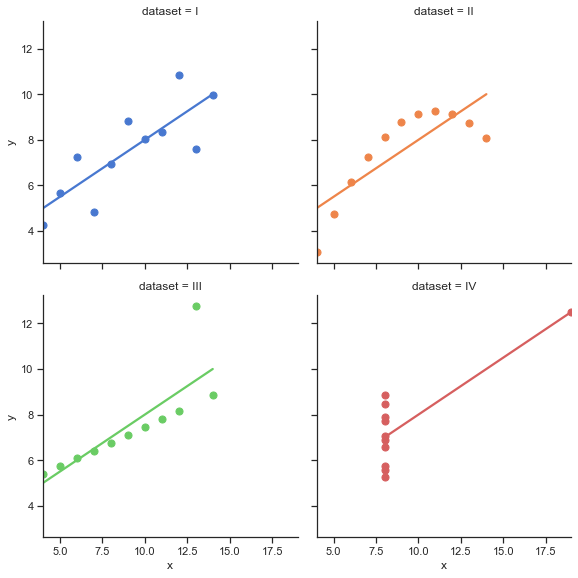

In [9]:
import seaborn as sns
sns.set_theme(style="ticks")
df = sns.load_dataset("anscombe")
sns.lmplot(x="x", y="y", col="dataset",
hue="dataset", data=df, col_wrap=2,
ci=None, palette="muted", height=4, scatter_kws={"s": 50, "alpha": 1})
plt.show()

For this exercise, let us quickly modify the function that we built in task `1` and put the LAD regression inside the function itself. In addition, we will also have it run a OLS regression and output its $R^2$.

In [10]:
def rsq_lad(y, x):
    """
    This function computes the R^2 of LAD and OLS.
    
    Parameters
    ----------
        y : array 
            The dependent variable
        x : array
            The independent variable
        
    Returns
    -------
        [rs_lad, rs_ols] : list
            The first element is the R^2 for lad, the second the R^2 for OLS.
    """
    
    # create dataframe
    data = pd.DataFrame(np.vstack((y,x)).T, columns=['y','x'])
    
    # run LAD regression
    res_lad = smf.quantreg("y ~ x", data = data).fit(q = 0.5)
    
    # compute the predicted values for LAD
    predictions_lad = res_lad.params[0] + x * res_lad.params[1]
    
    # run OLS regression
    res_ls = smf.ols("y ~ x", data = data).fit()
    
    # compute the predicted values for OLS
    predictions_ls = res_ls.params[0] + x * res_ls.params[1]
    
    # compute the elements of R^2 for LAD
    lower = np.sum(np.abs(y - np.median(y))) 
    upper = np.sum(np.abs(y - (predictions_lad)))
    
    # compute the R^2 for LAD
    rs_lad = np.max([(1 - upper / lower), 0])
    
    # compute the elements of R^2 for OLS
    lower = np.sum((y - np.mean(y))**2) 
    upper = np.sum((y - (predictions_ls))**2)
    
    # compute the R^2 for OLS
    rs_ls = np.max([(1 - upper / lower), 0])
    
    return [rs_lad, rs_ls] 

We can now run the regression of $y$ on $x$. If you have difficulty understanding the below code, have a look at the [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html). Essentially, `apply` allows to apply a function to columns or rows of a dataframe (In general, this tool is very useful and it's worth understanding and keeping in mind).

In [11]:
# run the regression for 
df.groupby("dataset").apply(lambda z: rsq_lad(z["y"],z["x"]))

dataset
I        [0.4627128367723099, 0.666542459508775]
II     [0.34691275114654974, 0.6662420337274844]
III     [0.7080765635401254, 0.6663240410665593]
IV     [0.35477582845294753, 0.6667072568984653]
dtype: object

As suggested by the exercise, we will now swap $x$ and $y$. First, let's plot the data with the inverted axis.

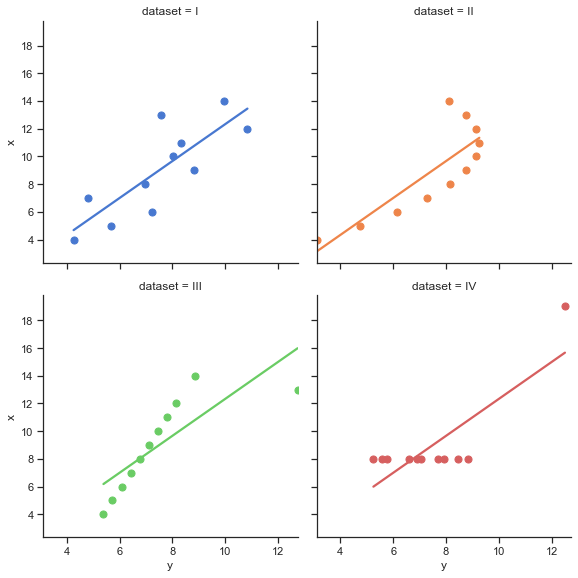

In [12]:
sns.lmplot(x="y", y="x", col="dataset", hue="dataset", data=df, col_wrap=2, ci = None, palette = "muted", height = 4, scatter_kws = {"s": 50, "alpha": 1})
plt.show()

Finally, compute the LAD pseudo $R^2$ of the regression of $x$ on $y$.

In [13]:
df.groupby("dataset").apply(lambda z: rsq_lad(z["x"],z["y"]))

dataset
I       [0.4608426094988298, 0.666542459508775]
II     [0.4912878530356105, 0.6662420337274841]
III    [0.5887820298746499, 0.6663240410665591]
IV                    [0.0, 0.6667072568984653]
dtype: object

As we can see, the OLS $R^2$ is always the same and invariant to swapping $x$ and $y$ as well as the "shape" of the data. The LAD $R^2$, however, is not the same across datasets and is also not symmetric. 


#### c) LAD correlation

As we can see from the lecture slides, in univariate regression, the $R^2$ is also equal to the squared correlation between $x$ and $y$. We can exploit this principle to come up with a "correlation" measure in the LAD case.

In [14]:
def corr_lad(y, x):
    
    """
    This function computes the R^2 of LAD and OLS.
    
    Parameters
    ----------
        y : array 
            The dependent variable
        x : array
            The independent variable
    
    Returns
    -------
        "Lad-correlation"
    """
    # create dataframe
    data = pd.DataFrame(np.vstack((y,x)).T, columns=['y','x'])
    
    # run a LAD regression
    res = smf.quantreg("y ~ x", data = data).fit(q = 0.5)
    
    # compute the elements of R^2 for LAD
    lower = np.sum(np.abs(y - np.median(y))) 
    upper = np.sum(np.abs(y - (res.params[0] + x * res.params[1])))
    
    # return the LAD-correlation
    return np.sign(res.params[1]) * np.max([(1 - upper / lower), 0])


Let us now quickly test our function on $x$ and $y$ from above.

In [15]:
corr_lad(y,x)

0.0924143316822903

### 3 Non-linear least squares

#### a) Estimator-plotter function

In [16]:
def nls_plotter(x, y, func, args):
    """
    Estimate the parameters of func (as in curve_fit)
    using non-linear least squares. Make a scatterplot of
    x and y and add the curve defined by func using the estimated
    parameters. Return the non-linear R squared.
    
    Parameters
    ----------
        x    : the independent variable
        y    : the dependent variable
        func : the functional form of the non-linear regression
        args : the true input arguments of the function
        
    Returns
    -------
        The R^2 of the non-linear regression.
    
    """
    
    # estimate the non-linear regression
    parameters = curve_fit(func, x, y)[0]
    
    # Plot scatter plot and function
    plt.scatter(x, y)
    plt.plot(x, func(x, *args), color = "black")
    plt.plot(x, func(x, *parameters), color = "red")
    plt.show()

    lower = np.sum((y2 - np.mean(y2)) ** 2) 
    upper = np.sum((y2 - func(x, *parameters)) ** 2) 
    
    return 1 - upper / lower

Note that the "unpacking" of input arguments is a critical part of the function, which allows to keep it flexible!

#### b) Four parameterized functions

To save space, we can put all functions into anonymous functions.

In [17]:
# function for the logistic curve
logistic = lambda x, a, b, c, d: a/(1+b**(x-c))+d
    
# function for the hyperbolic curve
hyperbolic = lambda x, a, b, c: a + b/(x+c)

# function for logarithmic curve
logarithmic = lambda x, a, b, c: a + b*x**c

# function for the exponential curve
exponential = lambda x, a, b, c: a + b*c**x

#### c) 4-plotter

First, we adjust out `nls_plotter` function, such that it takes a plot handle, `ax` as input. This will allow to plot into the subplots that are generated in `grid_plotter`. 

In [18]:
def nls_plotter(x, y, func, ax):
    """
    Estimate the parameters of func (as in curve_fit)
    using non-linear least squares. Make a scatterplot of
    x and y and add the curve defined by func using the estimated
    parameters. Return the non-linear R squared.
    
    Parameters
    ----------
        x    : the independent variable
        y    : the dependent variable
        func : the functional form of the non-linear regression
        args : the true input arguments of the function
        ax   : a plot handle
        
    Returns
    -------
        The R^2 of the non-linear regression.
    
    """
    
    # estimate the non-linear regression
    parameters = curve_fit(func, x, y)[0]
    
    ax.scatter(x, y)
    ax.plot(x, func(x, *parameters), color = "red")
    

    lower = np.sum((y - np.mean(y)) ** 2) 
    upper = np.sum((y - func(x, *parameters)) ** 2) 
    
    return 1 - upper / lower

Let's set `grid_plotter` up in a way, such that we can simply loop over the functions that we want to fit with NLS. 

In [19]:
def grid_plotter(y, x, functions, function_names):
    
    fig, ax = plt.subplots(4,1)
    
    r2_dict = {}
    for i, func in enumerate(functions):
        try:
            r2_dict[function_names[i]] = nls_plotter(x, y, func, ax[i])
        except:
            print('\nEstimation of ' + str(function_names[i]) + ' curve did not converge')
    return r2_dict

#### d) Application

In [20]:
from rdatasets import data
dataset = data("DNase")
dataset = dataset[dataset['Run'] == 1]
x = np.log(dataset["conc"])
y = dataset["density"]


Estimation of logarithmic curve did not converge


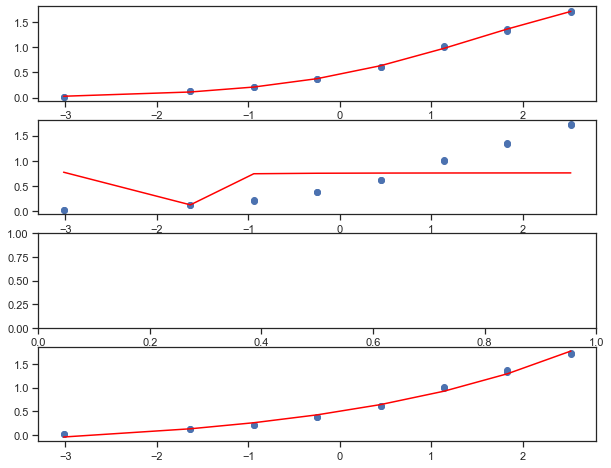

In [21]:
a = [logistic, hyperbolic, logarithmic, exponential]
b = ['logistic', 'hyperbolic', 'logarithmic', 'exponential']
a = grid_plotter(y, x, a, b)

Output the $R^2$.

In [22]:
# output the R^2 dictionary
a

{'logistic': 0.9991302139734051,
 'hyperbolic': 0.13043574757855525,
 'exponential': 0.9915054583356937}

The logistic function seems to fit the data best. 